In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _pickle as cPickle
import os
import sys
import tarfile

from six.moves import urllib
import tensorflow as tf

#from datasets import dataset_utils
import dataset_utils

In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# The URL where the CIFAR data can be downloaded.
_DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# The number of training files.
_NUM_TRAIN_FILES = 5

# The height and width of each image.
_IMAGE_SIZE = 32

# The names of the classes.
_CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]


def _add_to_tfrecord(filename, tfrecord_writer, offset=0):
  """Loads data from the cifar10 pickle files and writes files to a TFRecord.

  Args:
    filename: The filename of the cifar10 pickle file.
    tfrecord_writer: The TFRecord writer to use for writing.
    offset: An offset into the absolute number of images previously written.

  Returns:
    The new offset.
  """
  with tf.gfile.Open(filename, 'r') as f:
    data = cPickle.load(f)

  images = data['data']
  num_images = images.shape[0]

  images = images.reshape((num_images, 3, 32, 32))
  labels = data['labels']

  with tf.Graph().as_default():
    image_placeholder = tf.placeholder(dtype=tf.uint8)
    encoded_image = tf.image.encode_png(image_placeholder)

    with tf.Session('') as sess:

      for j in range(num_images):
        sys.stdout.write('\r>> Reading file [%s] image %d/%d' % (
            filename, offset + j + 1, offset + num_images))
        sys.stdout.flush()

        image = np.squeeze(images[j]).transpose((1, 2, 0))
        label = labels[j]

        png_string = sess.run(encoded_image,
                              feed_dict={image_placeholder: image})

        example = dataset_utils.image_to_tfexample(
            png_string, 'png', _IMAGE_SIZE, _IMAGE_SIZE, label)
        tfrecord_writer.write(example.SerializeToString())

  return offset + num_images


def _get_output_filename(dataset_dir, split_name):
  """Creates the output filename.

  Args:
    dataset_dir: The dataset directory where the dataset is stored.
    split_name: The name of the train/test split.

  Returns:
    An absolute file path.
  """
  return '%s/cifar10_%s.tfrecord' % (dataset_dir, split_name)


def _download_and_uncompress_dataset(dataset_dir):
  """Downloads cifar10 and uncompresses it locally.

  Args:
    dataset_dir: The directory where the temporary files are stored.
  """
  filename = _DATA_URL.split('/')[-1]
  filepath = os.path.join(dataset_dir, filename)

  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(_DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
    tarfile.open(filepath, 'r:gz').extractall(dataset_dir)


def _clean_up_temporary_files(dataset_dir):
  """Removes temporary files used to create the dataset.

  Args:
    dataset_dir: The directory where the temporary files are stored.
  """
  filename = _DATA_URL.split('/')[-1]
  filepath = os.path.join(dataset_dir, filename)
  tf.gfile.Remove(filepath)

  tmp_dir = os.path.join(dataset_dir, 'cifar-10-batches-py')
  tf.gfile.DeleteRecursively(tmp_dir)


def run(dataset_dir):
  """Runs the download and conversion operation.

  Args:
    dataset_dir: The dataset directory where the dataset is stored.
  """
  if not tf.gfile.Exists(dataset_dir):
    tf.gfile.MakeDirs(dataset_dir)

  training_filename = _get_output_filename(dataset_dir, 'train')
  testing_filename = _get_output_filename(dataset_dir, 'test')

  if tf.gfile.Exists(training_filename) and tf.gfile.Exists(testing_filename):
    print('Dataset files already exist. Exiting without re-creating them.')
    return

  dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)

  # First, process the training data:
  with tf.python_io.TFRecordWriter(training_filename) as tfrecord_writer:
    offset = 0
    for i in range(_NUM_TRAIN_FILES):
      filename = os.path.join(dataset_dir,
                              'cifar-10-batches-py',
                              'data_batch_%d' % (i + 1))  # 1-indexed.
      offset = _add_to_tfrecord(filename, tfrecord_writer, offset)

  # Next, process the testing data:
  with tf.python_io.TFRecordWriter(testing_filename) as tfrecord_writer:
    filename = os.path.join(dataset_dir,
                            'cifar-10-batches-py',
                            'test_batch')
    _add_to_tfrecord(filename, tfrecord_writer)

  # Finally, write the labels file:
  labels_to_class_names = dict(zip(range(len(_CLASS_NAMES)), _CLASS_NAMES))
  dataset_utils.write_label_file(labels_to_class_names, dataset_dir)

  _clean_up_temporary_files(dataset_dir)
  print('\nFinished converting the Cifar10 dataset!')

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(40,40, p=1),
                   RandomCrop(32,32, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

datagen = ImageDataGenerator(preprocessing_function=CustomImageDataGen)
datagen.fit(x_train)

In [26]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.5785433264160156 train acc: 0.42916 val loss: 1.4829878082275392 val acc: 0.4972 time: 56.254618644714355



epoch: 2 lr: 0.16 train loss: 0.8313980334472656 train acc: 0.70624 val loss: 1.0978179962158203 val acc: 0.6404 time: 91.12270998954773



epoch: 3 lr: 0.24 train loss: 0.6346867065429688 train acc: 0.77784 val loss: 0.6872012298583985 val acc: 0.7692 time: 126.8960337638855



epoch: 4 lr: 0.32 train loss: 0.5398150994873047 train acc: 0.8147 val loss: 0.8194885437011719 val acc: 0.7463 time: 162.49302744865417



epoch: 5 lr: 0.4 train loss: 0.4813526776123047 train acc: 0.8338 val loss: 1.0379884674072266 val acc: 0.6961 time: 198.06686115264893



epoch: 6 lr: 0.37894736842105264 train loss: 0.3951188690185547 train acc: 0.86432 val loss: 0.4927260772705078 val acc: 0.8353 time: 233.4895420074463



epoch: 7 lr: 0.35789473684210527 train loss: 0.3136867317199707 train acc: 0.89174 val loss: 0.6329937545776367 val acc: 0.8027 time: 268.36951994895935



epoch: 8 lr: 0.33684210526315794 train loss: 0.26450094955444337 train acc: 0.90894 val loss: 0.3390775115966797 val acc: 0.8831 time: 304.2326045036316



epoch: 9 lr: 0.31578947368421056 train loss: 0.22885255508422853 train acc: 0.92026 val loss: 0.38882208099365234 val acc: 0.8753 time: 339.6928017139435



epoch: 10 lr: 0.2947368421052632 train loss: 0.20168388206481933 train acc: 0.92836 val loss: 0.3400983825683594 val acc: 0.8842 time: 374.85913491249084



epoch: 11 lr: 0.2736842105263158 train loss: 0.17407440048217773 train acc: 0.93992 val loss: 0.38193459777832034 val acc: 0.8791 time: 410.17581844329834



epoch: 12 lr: 0.25263157894736843 train loss: 0.15035768203735353 train acc: 0.94814 val loss: 0.3103597023010254 val acc: 0.8982 time: 445.7186760902405



epoch: 13 lr: 0.23157894736842108 train loss: 0.1304091983795166 train acc: 0.95528 val loss: 0.3200274208068848 val acc: 0.8989 time: 481.46147775650024



epoch: 14 lr: 0.2105263157894737 train loss: 0.1087751806640625 train acc: 0.96246 val loss: 0.2759798503875732 val acc: 0.9136 time: 516.982825756073



epoch: 15 lr: 0.18947368421052635 train loss: 0.09543870811462403 train acc: 0.9676 val loss: 0.29659227294921875 val acc: 0.9099 time: 552.8545746803284



epoch: 16 lr: 0.16842105263157897 train loss: 0.07947386890411377 train acc: 0.97328 val loss: 0.32716478042602537 val acc: 0.9041 time: 588.69495677948



epoch: 17 lr: 0.1473684210526316 train loss: 0.06663610174179077 train acc: 0.97796 val loss: 0.2915942138671875 val acc: 0.9128 time: 624.3249475955963



epoch: 18 lr: 0.12631578947368421 train loss: 0.054598071269989015 train acc: 0.98268 val loss: 0.2778020896911621 val acc: 0.9191 time: 659.5757944583893



epoch: 19 lr: 0.10526315789473689 train loss: 0.04523635536193848 train acc: 0.98652 val loss: 0.2879825225830078 val acc: 0.9172 time: 694.4017190933228



epoch: 20 lr: 0.08421052631578951 train loss: 0.037382748012542724 train acc: 0.9888 val loss: 0.25598039169311526 val acc: 0.9254 time: 729.4234280586243



epoch: 21 lr: 0.06315789473684214 train loss: 0.030640257873535155 train acc: 0.99144 val loss: 0.282847274017334 val acc: 0.9223 time: 764.995861530304



epoch: 22 lr: 0.04210526315789476 train loss: 0.02552448642730713 train acc: 0.9935 val loss: 0.25730149307250977 val acc: 0.9299 time: 800.7518994808197



epoch: 23 lr: 0.02105263157894738 train loss: 0.023540194063186644 train acc: 0.99394 val loss: 0.25784559783935546 val acc: 0.9282 time: 835.7417826652527



epoch: 24 lr: 0.0 train loss: 0.02012947874069214 train acc: 0.9956 val loss: 0.2541731502532959 val acc: 0.9288 time: 870.6594190597534


In [0]:
import matplotlib.pyplot as plt
def plot_model_history(test_set):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(test_set.history['acc'])+1),test_set.history['acc'])
    axs[0].plot(range(1,len(test_set.history['val_acc'])+1),test_set.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(test_set.history['acc'])+1),len(test_set.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(test_set.history['loss'])+1), test_set.history['loss'])
    axs[1].plot(range(1,len(test_set.history['val_loss'])+1), test_set.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(test_set.history['loss'])+1),len(test_set.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

AttributeError: ignored

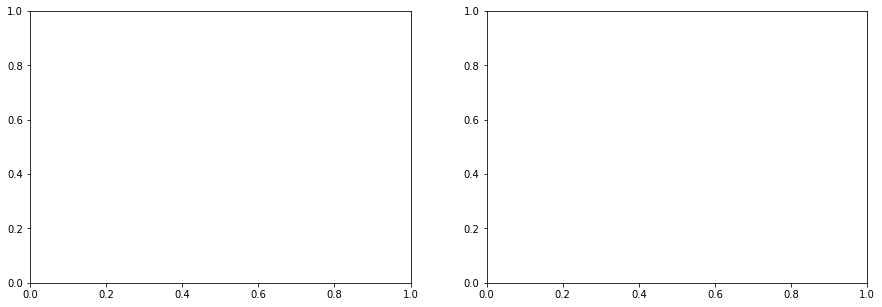

In [34]:
# plot model history
plot_model_history(test_set)